In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!pip install pyyaml h5py

In [ ]:
!gdown --id 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
From (redirected): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK&confirm=t&uuid=47946132-f82b-4563-8ff0-211aea269b0a
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:02<00:00, 17.0MB/s]


In [ ]:
!unzip -q hurricane_detector.zip

In [ ]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 May  8 19:58 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 May  7 13:22 sample_data/
drwxr-xr-x 4 root root     4096 May  8 19:58 test_hurricane/
drwxr-xr-x 4 root root     4096 May  8 19:58 train_hurricane/


In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (83.0 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121918 files and directories currently instal

In [ ]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage  [655 entries exceeds filelimit, not opening dir]
└── no_damage  [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage  [5895 entries exceeds filelimit, not opening dir]
└── no_damage  [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)


TF Version: 2.15.0


In [ ]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


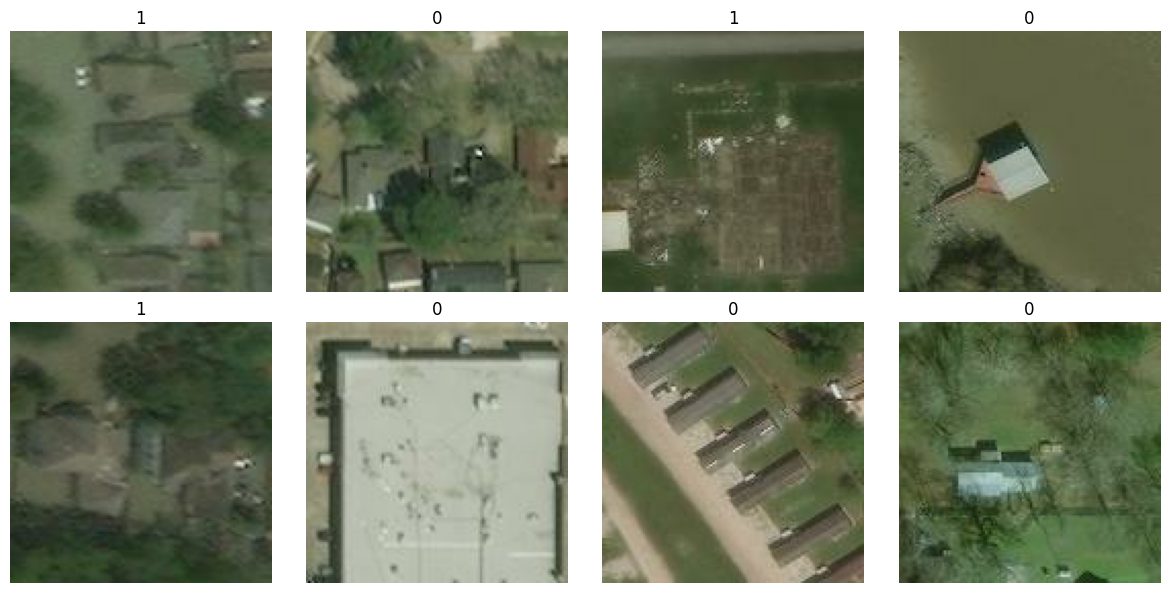

In [ ]:
  plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

In [ ]:
img_paths=[]
img_labels=[]
for i in glob('/content/train_hurricane/**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('/')
        img_paths.append(i)
        img_labels.append(a[-2])
len(img_paths),len(img_labels)

(1358, 1358)

In [ ]:
img_paths2=[]
img_labels2=[]
for i in glob('/content/test_hurricane/**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('/')
        img_paths2.append(i)
        img_labels2.append(a[-2])
len(img_paths2),len(img_labels2)


img_path2 = pd.Series(img_paths2).astype(str)
labels2=pd.Series(img_labels2)
data_test = pd.concat([img_path2,labels2],axis=1)
data_test.columns = ['path','classes']

img_path = pd.Series(img_paths).astype(str)
labels=pd.Series(img_labels)
data = pd.concat([img_path,labels],axis=1)
data.columns = ['path','classes']

classes
no_damage    703
damage       655
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='classes'>

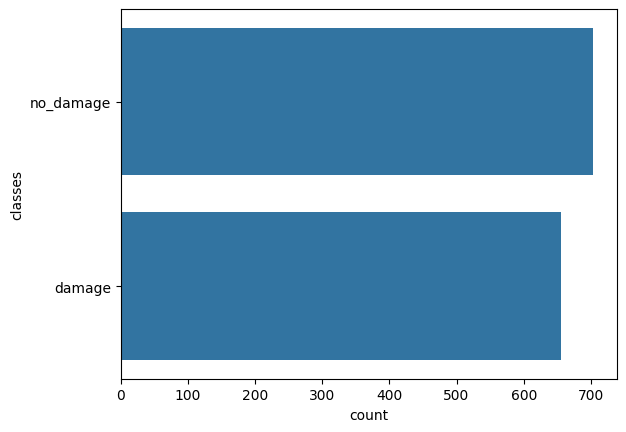

In [ ]:
display(data.classes.value_counts())
print('='*100)
sns.countplot(data.classes)


classes
no_damage    6333
damage       5895
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='classes'>

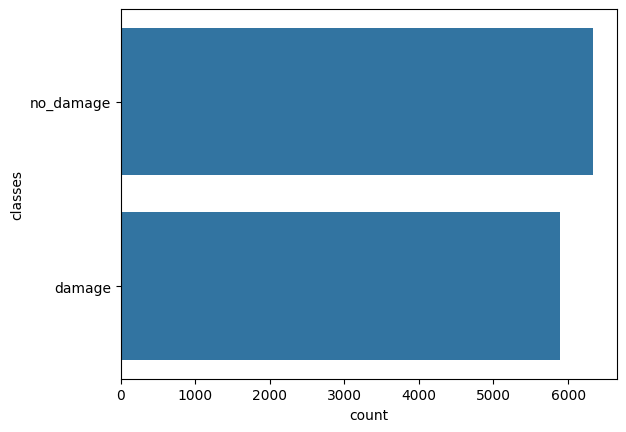

In [ ]:
display(data_test.classes.value_counts())
print('='*100)
sns.countplot(data_test.classes)


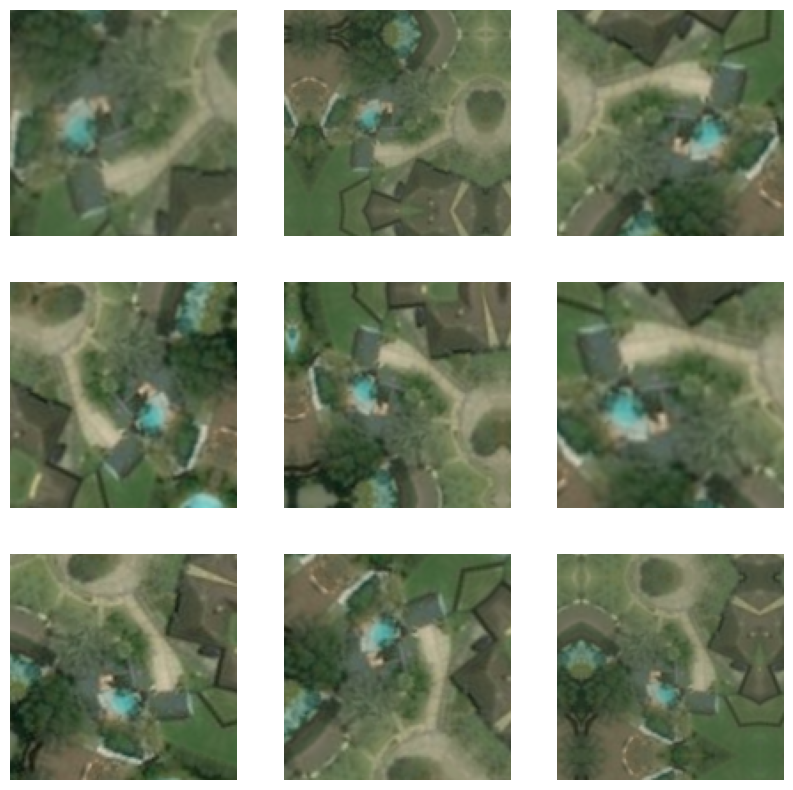

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
  tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
])


# visualizing the result of augmentation on one image
for image, labels in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
print('Imaged shape and dimensions:')

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Imaged shape and dimensions:
(32, 128, 128, 3)
(32,)


In [ ]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')])

model.build(input_shape=((None, 128, 128, 3)))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  epochs=epochs,
  validation_data=val_ds)

Epoch 1/20
34/34 [==============================] - 8s 43ms/step - loss: 0.6849 - accuracy: 0.5382 - val_loss: 0.6350 - val_accuracy: 0.7786
Epoch 2/20
34/34 [==============================] - 1s 35ms/step - loss: 0.6155 - accuracy: 0.6716 - val_loss: 0.6736 - val_accuracy: 0.5793
Epoch 3/20
34/34 [==============================] - 1s 20ms/step - loss: 0.5767 - accuracy: 0.7323 - val_loss: 0.6045 - val_accuracy: 0.7048
Epoch 4/20
34/34 [==============================] - 1s 31ms/step - loss: 0.5753 - accuracy: 0.7121 - val_loss: 0.4986 - val_accuracy: 0.8118
Epoch 5/20
34/34 [==============================] - 1s 32ms/step - loss: 0.5176 - accuracy: 0.7461 - val_loss: 0.4968 - val_accuracy: 0.7934
Epoch 6/20
34/34 [==============================] - 1s 22ms/step - loss: 0.5062 - accuracy: 0.7645 - val_loss: 0.6109 - val_accuracy: 0.7196
Epoch 7/20
34/34 [==============================] - 1s 18ms/step - loss: 0.5909 - accuracy: 0.7029 - val_loss: 0.5325 - val_accuracy: 0.7675
Epoch 8/20
34

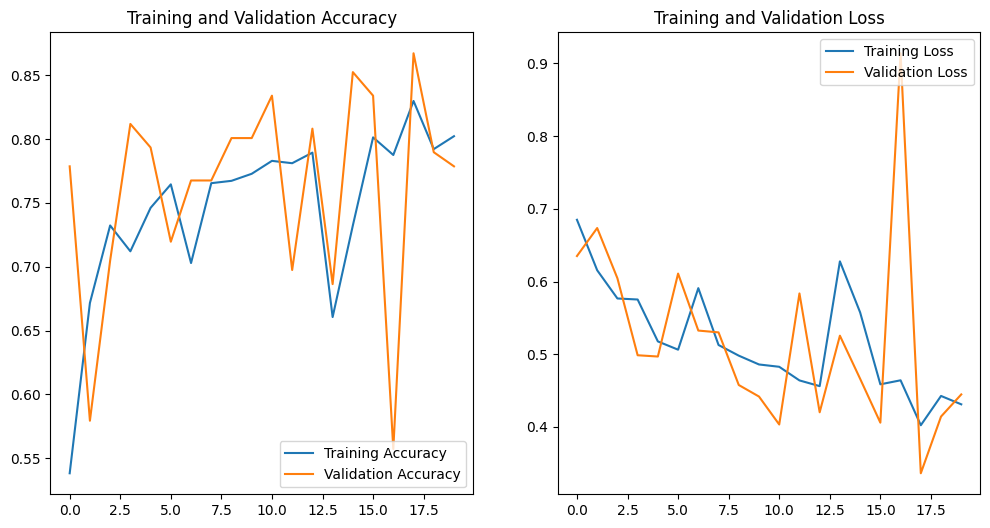

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Found 12228 files belonging to 2 classes.
383/383 [==============================] - 5s 13ms/step - loss: 0.4876 - accuracy: 0.7664
Test accuracy: 0.7663559317588806
383/383 [==============================] - 5s 13ms/step
Confusion Matrix:
[[4502 1831]
 [4220 1675]]


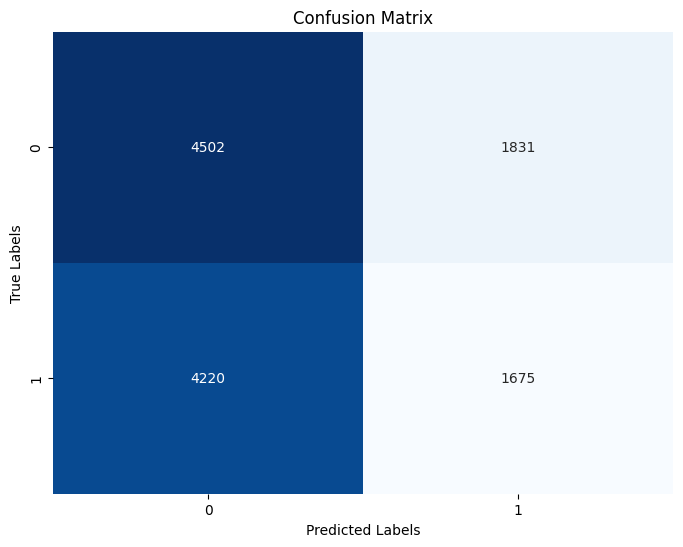

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.71      0.60      6333
           1       0.48      0.28      0.36      5895

    accuracy                           0.51     12228
   macro avg       0.50      0.50      0.48     12228
weighted avg       0.50      0.51      0.48     12228

Sensitivity: 0.28413910093299405
Recall: 0.28413910093299405
Precision: 0.4777524244152881
F1 Score: 0.356345069673439


In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define and load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./test_hurricane",  # Replace "./test_hurricane" with the actual path to your test dataset directory
    class_names=['no_damage', 'damage'],  # Adjust class names as needed
    seed=42,
    image_size=(128, 128),  # Adjust image size as needed
    batch_size=32  # Adjust batch size as needed
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

# Predict labels for the test dataset
predictions = (model.predict(test_ds) > 0.5).astype("int32")

# Get true labels
true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Compute confusion matrix
conf_mat = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:')
print(conf_mat)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute classification report
print('Classification Report:')
print(classification_report(true_labels, predictions))

# Compute sensitivity, recall, precision, and F1 score
tn, fp, fn, tp = conf_mat.ravel()
sensitivity = tp / (tp + fn)
recall = sensitivity
precision = tp / (tp + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Sensitivity: {sensitivity}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1_score}')


94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/20
34/34 [==============================] - 8s 132ms/step - loss: 0.3813 - accuracy: 0.8454 - val_loss: 0.3651 - val_accuracy: 0.8561
Epoch 2/20
34/34 [==============================] - 2s 47ms/step - 

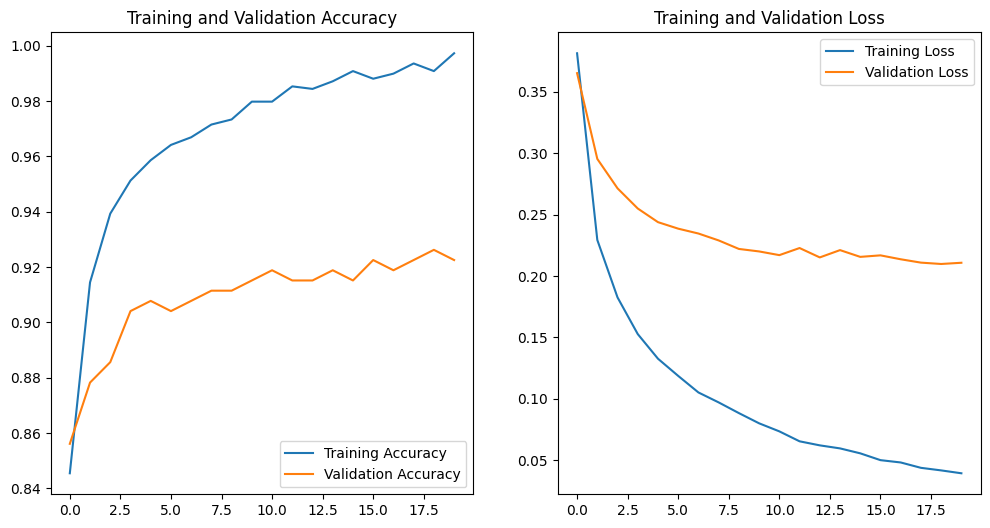

In [ ]:
from tensorflow.keras.applications import ResNet50

IMAGE_SIZE = [128, 128]

# Load the ResNet50 model
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the layers in the ResNet50 model
for layer in resnet.layers:
    layer.trainable = False

# Print the summary of the ResNet50 model
resnet.summary()

# Choose the layers to fine-tune
for layer in resnet.layers[-5:]:
    print(layer.name)

# Define a global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Get the output of the ResNet50 model and pass it through the global average pooling layer
feature_batch = resnet(image_batch)
feature_batch_average = global_average_layer(feature_batch)

# Define the prediction layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Combine the ResNet50 model with the global average pooling layer and the prediction layer
model_resnet = tf.keras.Sequential([resnet, global_average_layer, prediction_layer])

# Compile the model
base_learning_rate = 0.0001
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Print the summary of the model
model_resnet.summary()

# Train the model
history_resnet = model_resnet.fit(train_ds, epochs=20, validation_data=val_ds)

# Plot the training history
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']

loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 3s 70ms/step


Predicting on Test Data:   1%|          | 1/96 [00:04<07:03,  4.46s/it]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:05<03:29,  2.23s/it]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:05<02:26,  1.58s/it]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:06<01:49,  1.19s/it]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:07<01:28,  1.02it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:07<01:13,  1.23it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:08<01:02,  1.43it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:08<01:02,  1.41it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:09<00:55,  1.56it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:10<00:57,  1.49it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:10<00:52,  1.61it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:11<00:48,  1.73it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:11<00:52,  1.60it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:12<00:54,  1.51it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:12<00:48,  1.66it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:13<00:45,  1.76it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:14<00:49,  1.61it/s]

4/4 [==============================] - 0s 84ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:14<00:44,  1.74it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:15<00:42,  1.83it/s]

4/4 [==============================] - 0s 83ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:15<00:47,  1.60it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:16<00:49,  1.51it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:17<00:46,  1.58it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:18<00:52,  1.40it/s]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:18<00:52,  1.37it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:19<00:54,  1.31it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:20<00:47,  1.47it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:20<00:42,  1.62it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:21<00:44,  1.53it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:22<00:42,  1.59it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:22<00:38,  1.71it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:23<00:40,  1.59it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:24<00:42,  1.51it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:24<00:42,  1.47it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:25<00:43,  1.41it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:26<00:43,  1.40it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:26<00:38,  1.55it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:27<00:36,  1.60it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:28<00:38,  1.53it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:28<00:34,  1.64it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:29<00:31,  1.75it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:29<00:34,  1.61it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:30<00:34,  1.57it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:31<00:37,  1.41it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:32<00:38,  1.36it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:32<00:33,  1.52it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:33<00:35,  1.42it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:34<00:35,  1.40it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:34<00:31,  1.55it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:35<00:31,  1.49it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:36<00:31,  1.45it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:36<00:31,  1.43it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:37<00:31,  1.41it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:38<00:27,  1.55it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:38<00:28,  1.49it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:39<00:29,  1.40it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:40<00:28,  1.39it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:41<00:28,  1.38it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:41<00:27,  1.36it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:42<00:26,  1.39it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:43<00:25,  1.41it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:43<00:26,  1.34it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:44<00:23,  1.44it/s]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:45<00:21,  1.56it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:46<00:24,  1.33it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:46<00:21,  1.42it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:47<00:22,  1.30it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:48<00:21,  1.32it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:48<00:18,  1.48it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:49<00:16,  1.60it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:49<00:15,  1.71it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:50<00:15,  1.59it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:51<00:16,  1.49it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:51<00:14,  1.62it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:52<00:14,  1.53it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:53<00:14,  1.48it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:53<00:12,  1.61it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:54<00:12,  1.52it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:55<00:11,  1.52it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:55<00:11,  1.54it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:56<00:11,  1.44it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:57<00:11,  1.36it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:58<00:10,  1.36it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:58<00:09,  1.36it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:59<00:08,  1.36it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [01:00<00:08,  1.36it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [01:01<00:07,  1.36it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [01:01<00:05,  1.51it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [01:02<00:04,  1.63it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [01:02<00:04,  1.50it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [01:03<00:04,  1.44it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [01:04<00:03,  1.57it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [01:04<00:02,  1.69it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [01:05<00:01,  1.80it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [01:05<00:01,  1.66it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [01:06<00:00,  1.58it/s]

3/3 [==============================] - 2s 536ms/step


Predicting on Test Data: 100%|██████████| 96/96 [01:21<00:00,  1.17it/s]


Confusion Matrix:
[[3103 3230]
 [3119 2776]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      6333
           1       0.46      0.47      0.47      5895

    accuracy                           0.48     12228
   macro avg       0.48      0.48      0.48     12228
weighted avg       0.48      0.48      0.48     12228



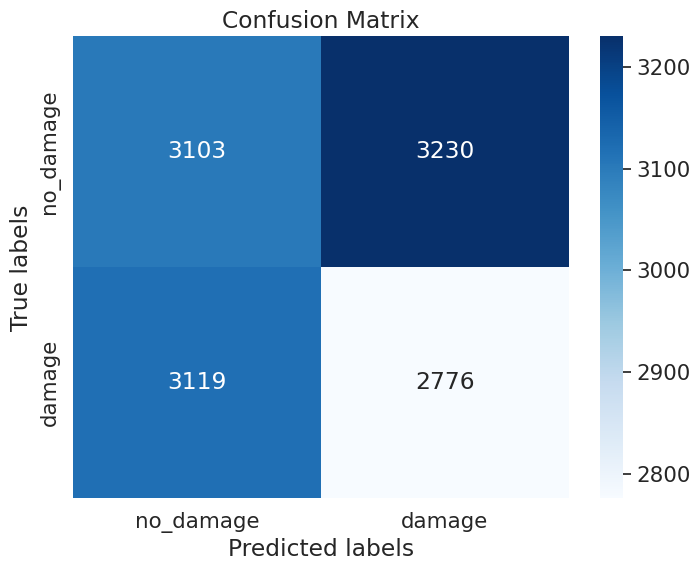

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# Function to load ResNet50 model with pretrained weights
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Adding a fully-connected layer
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Output layer
    model = Model(inputs=base_model.input, outputs=predictions)
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    return model

# Function to evaluate ResNet50 model on test data
def eval_resnet_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=(224, 224),  # ResNet50 requires input size of 224x224
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

# Create and compile ResNet50 model
resnet_model = create_resnet_model()
resnet_model.compile(optimizer='adam',
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

# Train the model (you can use the train_ds and val_ds here)

# Evaluate ResNet50 model on test data
test_labels, predictions = eval_resnet_model_on_test(resnet_model)

# Sensitivity, F1-score, precision, recall
conf_matrix = confusion_matrix(test_labels, predictions.round())
classification_rep = classification_report(test_labels, predictions.round())

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

sns.set(font_scale=1.4)  # Adjust font size
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['no_damage', 'damage'], yticklabels=['no_damage', 'damage'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_4[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7038529 (26.85 MB)
Trainable params: 1025 (4.00 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________
Epoch 1/20
34/34 [==============================] - 20s 318ms/step - loss: 0.9045 - accuracy: 0.6283 - val_loss: 0.6047 - val_accuracy: 0.7306
Epoch 2/20
34/34 [==============================] - 2s 57ms/step - l

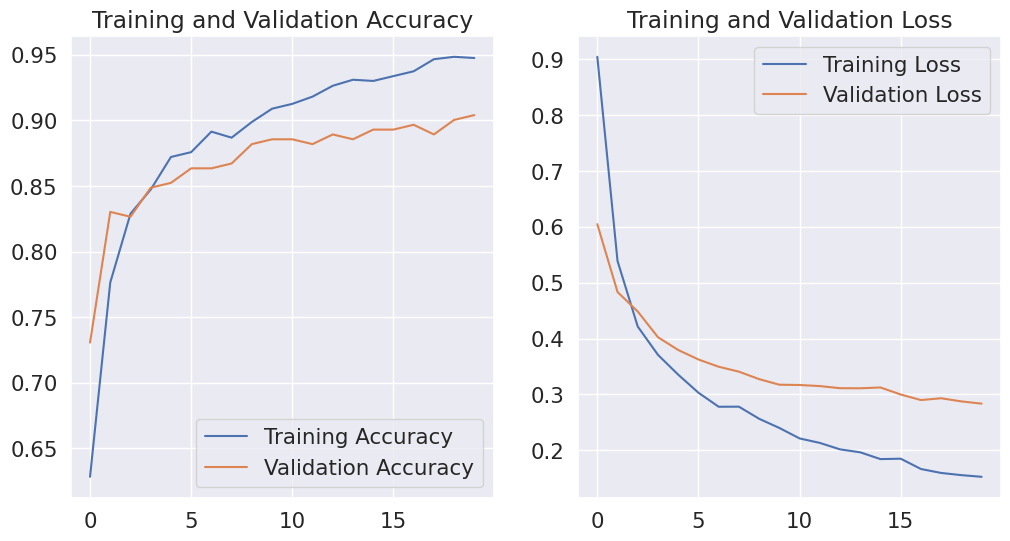

In [ ]:
from tensorflow.keras.applications import DenseNet121

IMAGE_SIZE = [128, 128]

# Load the DenseNet121 model
densenet = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the layers in the DenseNet121 model
for layer in densenet.layers:
    layer.trainable = False

# Print the summary of the DenseNet121 model
densenet.summary()

# Choose the layers to fine-tune
for layer in densenet.layers[-5:]:
    print(layer.name)

# Define a global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Get the output of the DenseNet121 model and pass it through the global average pooling layer
feature_batch = densenet(image_batch)
feature_batch_average = global_average_layer(feature_batch)

# Define the prediction layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Combine the DenseNet121 model with the global average pooling layer and the prediction layer
model_densenet = tf.keras.Sequential([densenet, global_average_layer, prediction_layer])

# Compile the model
base_learning_rate = 0.0001
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Print the summary of the model
model_densenet.summary()

# Train the model
history_densenet = model_densenet.fit(train_ds, epochs=20, validation_data=val_ds)

# Plot the training history
acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']

loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 6s 71ms/step


Predicting on Test Data:   1%|          | 1/96 [00:07<11:22,  7.19s/it]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:08<05:31,  3.52s/it]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:08<03:29,  2.25s/it]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:09<02:23,  1.56s/it]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:09<01:47,  1.18s/it]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:10<01:24,  1.06it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:11<01:19,  1.12it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:11<01:14,  1.18it/s]

4/4 [==============================] - 0s 85ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:12<01:10,  1.23it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:13<01:00,  1.41it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:13<00:54,  1.56it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:14<00:55,  1.50it/s]

4/4 [==============================] - 0s 81ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:15<00:57,  1.45it/s]

4/4 [==============================] - 0s 84ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:15<00:57,  1.42it/s]

4/4 [==============================] - 0s 84ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:16<00:59,  1.36it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:17<00:59,  1.35it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:18<00:58,  1.35it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:18<00:51,  1.50it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:19<00:53,  1.45it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:20<00:58,  1.31it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:21<00:59,  1.25it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:21<00:52,  1.41it/s]

4/4 [==============================] - 0s 85ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:22<00:52,  1.39it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:23<00:54,  1.33it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:24<00:53,  1.33it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:24<00:46,  1.49it/s]

4/4 [==============================] - 0s 85ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:24<00:42,  1.61it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:25<00:44,  1.52it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:26<00:45,  1.46it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:26<00:41,  1.61it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:27<00:42,  1.53it/s]

4/4 [==============================] - 0s 85ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:28<00:38,  1.65it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:28<00:37,  1.69it/s]

4/4 [==============================] - 0s 85ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:29<00:35,  1.76it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:29<00:37,  1.61it/s]

4/4 [==============================] - 0s 82ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:30<00:34,  1.72it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:30<00:33,  1.79it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:31<00:35,  1.62it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:32<00:35,  1.62it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:33<00:38,  1.44it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:33<00:38,  1.43it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:34<00:38,  1.39it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:35<00:34,  1.54it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:35<00:31,  1.66it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:36<00:32,  1.55it/s]

4/4 [==============================] - 0s 85ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:36<00:30,  1.67it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:37<00:28,  1.70it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:38<00:30,  1.58it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:38<00:31,  1.51it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:39<00:29,  1.56it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:40<00:26,  1.68it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:40<00:27,  1.57it/s]

4/4 [==============================] - 0s 85ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:41<00:28,  1.50it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:42<00:28,  1.45it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:42<00:28,  1.42it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:43<00:28,  1.39it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:44<00:29,  1.30it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:45<00:30,  1.25it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:46<00:28,  1.31it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:46<00:27,  1.32it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:47<00:26,  1.33it/s]

4/4 [==============================] - 0s 83ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:48<00:22,  1.48it/s]

4/4 [==============================] - 0s 84ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:48<00:22,  1.44it/s]

4/4 [==============================] - 0s 81ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:49<00:22,  1.41it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:50<00:22,  1.39it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:51<00:22,  1.36it/s]

4/4 [==============================] - 0s 89ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:51<00:22,  1.31it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:52<00:19,  1.45it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:53<00:19,  1.41it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:53<00:16,  1.56it/s]

4/4 [==============================] - 0s 85ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:54<00:16,  1.49it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:54<00:14,  1.61it/s]

4/4 [==============================] - 0s 84ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:55<00:15,  1.52it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:56<00:14,  1.57it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:57<00:13,  1.53it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:57<00:15,  1.33it/s]

4/4 [==============================] - 0s 86ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:58<00:13,  1.42it/s]

4/4 [==============================] - 0s 83ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:59<00:11,  1.54it/s]

4/4 [==============================] - 0s 85ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:59<00:10,  1.67it/s]

4/4 [==============================] - 0s 85ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [01:00<00:09,  1.76it/s]

4/4 [==============================] - 0s 84ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [01:00<00:09,  1.61it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [01:01<00:08,  1.73it/s]

4/4 [==============================] - 0s 84ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [01:02<00:08,  1.59it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [01:02<00:07,  1.65it/s]

4/4 [==============================] - 0s 83ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [01:03<00:06,  1.75it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [01:03<00:05,  1.83it/s]

4/4 [==============================] - 0s 87ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [01:04<00:04,  1.90it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [01:04<00:04,  1.95it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [01:05<00:04,  1.72it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [01:05<00:03,  1.81it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [01:06<00:03,  1.64it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [01:07<00:02,  1.54it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [01:07<00:01,  1.64it/s]

4/4 [==============================] - 0s 88ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [01:08<00:01,  1.76it/s]

4/4 [==============================] - 0s 90ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [01:08<00:00,  1.61it/s]

3/3 [==============================] - 5s 1s/step


Predicting on Test Data: 100%|██████████| 96/96 [01:21<00:00,  1.17it/s]


Confusion Matrix:
[[5442  891]
 [4028 1867]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.86      0.69      6333
           1       0.68      0.32      0.43      5895

    accuracy                           0.60     12228
   macro avg       0.63      0.59      0.56     12228
weighted avg       0.62      0.60      0.56     12228



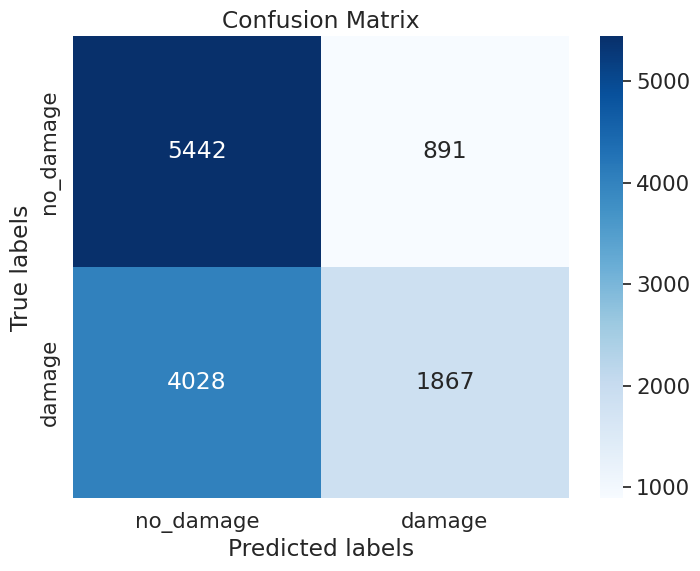

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# Function to load DenseNet121 model with pretrained weights
def create_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Adding a fully-connected layer
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Output layer
    model = Model(inputs=base_model.input, outputs=predictions)
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    return model

# Function to evaluate DenseNet121 model on test data
def eval_densenet_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=(224, 224),  # DenseNet121 requires input size of 224x224
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

# Create and compile DenseNet121 model
densenet_model = create_densenet_model()
densenet_model.compile(optimizer='adam',
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=['accuracy'])

# Train the model (you can use the train_ds and val_ds here)

# Evaluate DenseNet121 model on test data
test_labels, predictions = eval_densenet_model_on_test(densenet_model)

# Sensitivity, F1-score, precision, recall
conf_matrix = confusion_matrix(test_labels, predictions.round())
classification_rep = classification_report(test_labels, predictions.round())

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

sns.set(font_scale=1.4)  # Adjust font size
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['no_damage', 'damage'], yticklabels=['no_damage', 'damage'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, 124, 124, 6)       456       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 29, 29, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 13456)             0         
                                                                 
 dense_13 (Dense)            (None, 120)              

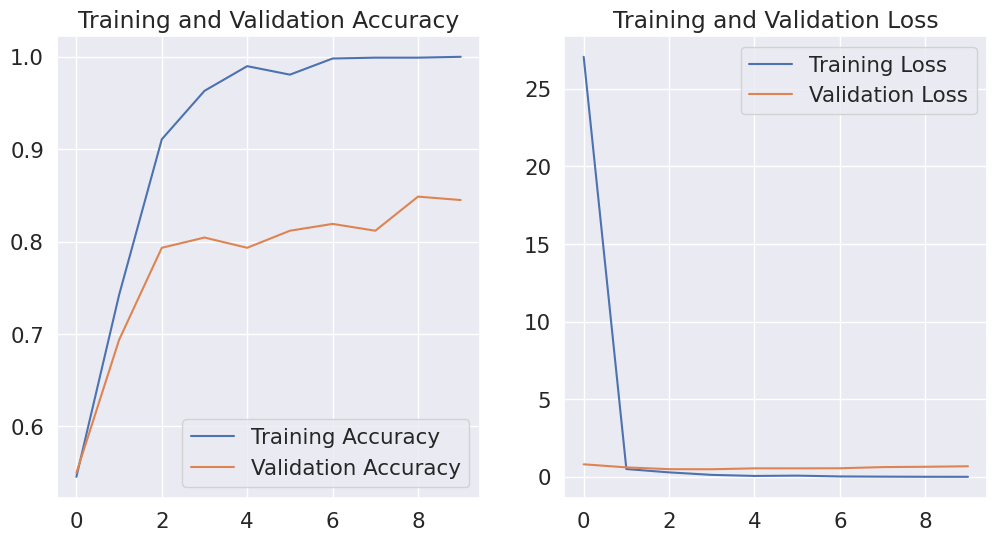

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define LeNet architecture
model_lenet = tf.keras.Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=IMG_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
base_learning_rate = 0.0001
model_lenet.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Print the summary of the model
model_lenet.summary()

# Train the model
history_lenet = model_lenet.fit(train_ds, epochs=10, validation_data=val_ds)

# Plot the training history
acc = history_lenet.history['accuracy']
val_acc = history_lenet.history['val_accuracy']

loss = history_lenet.history['loss']
val_loss = history_lenet.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   1%|          | 1/96 [00:01<01:52,  1.18s/it]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:01<01:20,  1.17it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:02<01:00,  1.53it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:02<00:43,  2.12it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:02<00:34,  2.62it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:02<00:26,  3.41it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:02<00:20,  4.29it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:02<00:16,  5.21it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:03<00:14,  5.97it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:03<00:12,  6.74it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:03<00:11,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:03<00:10,  7.86it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:03<00:10,  8.14it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:03<00:09,  8.31it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:04<00:22,  3.59it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:04<00:18,  4.35it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:04<00:15,  5.18it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:04<00:13,  5.91it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:04<00:12,  6.37it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:04<00:10,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:04<00:10,  7.45it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:05<00:09,  7.86it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:05<00:08,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:05<00:08,  8.42it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:05<00:08,  8.51it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:05<00:08,  8.59it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:05<00:07,  8.73it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:05<00:07,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:05<00:07,  8.74it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:05<00:07,  8.94it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:06<00:07,  8.75it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:06<00:07,  8.78it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:06<00:07,  8.80it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:06<00:06,  8.88it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:06<00:06,  8.87it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:06<00:06,  9.04it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:06<00:06,  9.05it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:06<00:06,  8.84it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:06<00:06,  8.90it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:07<00:06,  8.70it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:07<00:06,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:07<00:06,  8.82it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:07<00:06,  8.78it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:07<00:05,  8.75it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:07<00:05,  8.92it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:07<00:05,  9.02it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:07<00:05,  8.75it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:08<00:05,  8.84it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:08<00:05,  8.70it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:08<00:05,  8.73it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:08<00:05,  8.58it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:08<00:05,  8.76it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:08<00:04,  8.99it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:08<00:04,  9.03it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:08<00:04,  8.96it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:08<00:04,  8.83it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:09<00:04,  8.77it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:09<00:04,  8.72it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:09<00:04,  8.70it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:09<00:04,  8.66it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:09<00:04,  8.75it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:09<00:03,  8.51it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:09<00:03,  8.75it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:09<00:03,  8.80it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:09<00:03,  8.61it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:10<00:03,  8.60it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:10<00:03,  8.68it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:10<00:03,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:10<00:03,  8.64it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:10<00:02,  8.77it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:10<00:02,  8.85it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:10<00:02,  9.03it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:10<00:02,  9.09it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:10<00:02,  8.71it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:11<00:02,  8.56it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:11<00:02,  8.69it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:11<00:02,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:11<00:02,  8.59it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:11<00:01,  8.80it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:11<00:01,  8.98it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:11<00:01,  8.93it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:11<00:01,  8.97it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:12<00:01,  8.37it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:12<00:01,  8.40it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:12<00:01,  8.41it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:12<00:01,  8.38it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:12<00:01,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:12<00:00,  8.81it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:12<00:00,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:12<00:00,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:13<00:00,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:13<00:00,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:13<00:00,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:13<00:00,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:13<00:00,  6.50it/s]

3/3 [==============================] - 0s 46ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:14<00:00,  6.82it/s]


Confusion Matrix:
[[ 236 6097]
 [ 291 5604]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.04      0.07      6333
           1       0.48      0.95      0.64      5895

    accuracy                           0.48     12228
   macro avg       0.46      0.49      0.35     12228
weighted avg       0.46      0.48      0.34     12228



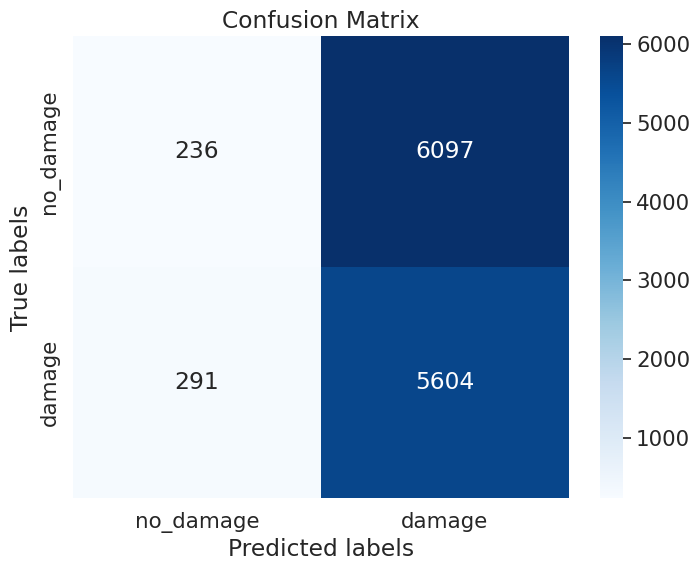

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Define LeNet model architecture
def create_lenet_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Function to evaluate LeNet model on test data
def eval_lenet_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=(28, 28),  # LeNet requires input size of 28x28
        batch_size=128,
        color_mode='grayscale'  # Grayscale images
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

# Create and compile LeNet model
lenet_model = create_lenet_model()
lenet_model.compile(optimizer='adam',
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy'])

# Evaluate LeNet model on test data
test_labels, predictions = eval_lenet_model_on_test(lenet_model)

# Sensitivity, F1-score, precision, recall
conf_matrix = confusion_matrix(test_labels, predictions.round())
classification_rep = classification_report(test_labels, predictions.round())

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

sns.set(font_scale=1.4)  # Adjust font size
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['no_damage', 'damage'], yticklabels=['no_damage', 'damage'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_103 (Conv2D)         (None, 63, 63, 32)           864       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 63, 63, 32)           96        ['conv2d_103[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 63, 63, 32)           0         ['batch_normalizati

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_19 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch 1/20
34/34 [==============================] - 10s 76ms/step - loss: 8.4373 - accuracy: 0.6320 - val_loss: 3.9330 - val_accuracy: 0.7970
Epoch 2/20
34/34 [==============================] - 1s 37ms/step - 

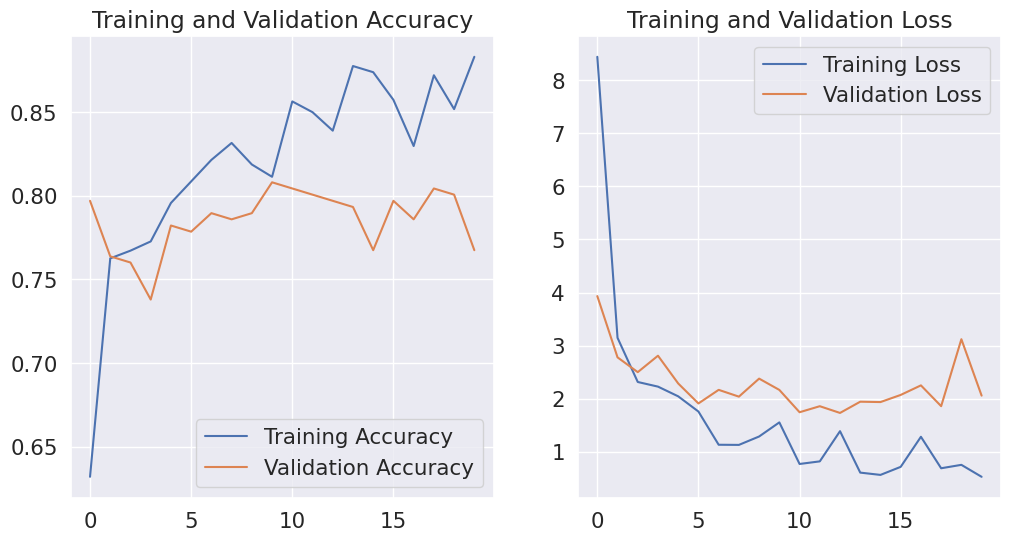

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Define input shape for InceptionV3
IMG_SHAPE = (128, 128, 3)

# Load the InceptionV3 model
inceptionv3 = InceptionV3(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

# Freeze the layers in the InceptionV3 model
for layer in inceptionv3.layers:
    layer.trainable = False

# Print the summary of the InceptionV3 model
inceptionv3.summary()

# Define a global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Get the output of the InceptionV3 model and pass it through the global average pooling layer
feature_batch = inceptionv3(image_batch)
feature_batch_average = global_average_layer(feature_batch)

# Define the prediction layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Combine the InceptionV3 model with the global average pooling layer and the prediction layer
model_inceptionv3 = tf.keras.Sequential([inceptionv3, global_average_layer, prediction_layer])

# Compile the model
base_learning_rate = 0.0001
model_inceptionv3.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Print the summary of the model
model_inceptionv3.summary()

# Train the model
history_inceptionv3 = model_inceptionv3.fit(train_ds, epochs=20, validation_data=val_ds)

# Plot the training history
acc = history_inceptionv3.history['accuracy']
val_acc = history_inceptionv3.history['val_accuracy']

loss = history_inceptionv3.history['loss']
val_loss = history_inceptionv3.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 7s 86ms/step


Predicting on Test Data:   1%|          | 1/96 [00:13<20:39, 13.05s/it]

4/4 [==============================] - 0s 134ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:13<09:01,  5.76s/it]

4/4 [==============================] - 0s 114ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:14<05:18,  3.43s/it]

4/4 [==============================] - 0s 118ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:14<03:33,  2.32s/it]

4/4 [==============================] - 0s 117ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:15<02:36,  1.72s/it]

4/4 [==============================] - 0s 113ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:16<02:04,  1.39s/it]

4/4 [==============================] - 0s 111ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:17<01:44,  1.18s/it]

4/4 [==============================] - 0s 122ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:17<01:28,  1.00s/it]

4/4 [==============================] - 1s 111ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:18<01:24,  1.03it/s]

4/4 [==============================] - 1s 115ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:19<01:19,  1.08it/s]

4/4 [==============================] - 0s 111ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:20<01:23,  1.02it/s]

4/4 [==============================] - 0s 116ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:21<01:13,  1.14it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:21<01:09,  1.20it/s]

4/4 [==============================] - 0s 113ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:22<01:02,  1.32it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:23<00:58,  1.38it/s]

4/4 [==============================] - 0s 116ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:23<00:56,  1.42it/s]

4/4 [==============================] - 0s 119ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:24<00:53,  1.47it/s]

4/4 [==============================] - 0s 114ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:25<00:54,  1.42it/s]

4/4 [==============================] - 0s 114ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:25<00:54,  1.41it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:26<00:58,  1.30it/s]

4/4 [==============================] - 0s 119ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:27<00:56,  1.32it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:28<00:52,  1.40it/s]

4/4 [==============================] - 0s 114ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:28<00:52,  1.38it/s]

4/4 [==============================] - 0s 111ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:29<00:52,  1.37it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:30<00:51,  1.37it/s]

4/4 [==============================] - 1s 136ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:31<00:50,  1.38it/s]

4/4 [==============================] - 1s 124ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:32<00:53,  1.28it/s]

4/4 [==============================] - 1s 118ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:32<00:55,  1.22it/s]

4/4 [==============================] - 1s 113ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:33<00:56,  1.19it/s]

4/4 [==============================] - 0s 117ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:34<00:53,  1.24it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:35<00:49,  1.32it/s]

4/4 [==============================] - 0s 119ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:35<00:48,  1.33it/s]

4/4 [==============================] - 0s 116ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:36<00:45,  1.39it/s]

4/4 [==============================] - 0s 117ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:37<00:42,  1.46it/s]

4/4 [==============================] - 0s 118ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:37<00:40,  1.50it/s]

4/4 [==============================] - 0s 118ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:38<00:39,  1.52it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:39<00:43,  1.37it/s]

4/4 [==============================] - 0s 117ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:40<00:41,  1.41it/s]

4/4 [==============================] - 0s 112ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:40<00:38,  1.47it/s]

4/4 [==============================] - 0s 116ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:41<00:37,  1.49it/s]

4/4 [==============================] - 0s 118ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:41<00:36,  1.51it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:42<00:35,  1.53it/s]

4/4 [==============================] - 0s 118ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:43<00:35,  1.48it/s]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:44<00:36,  1.44it/s]

4/4 [==============================] - 1s 125ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:44<00:37,  1.37it/s]

4/4 [==============================] - 0s 120ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:45<00:40,  1.22it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:46<00:38,  1.28it/s]

4/4 [==============================] - 0s 117ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:47<00:35,  1.34it/s]

4/4 [==============================] - 0s 111ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:47<00:33,  1.39it/s]

4/4 [==============================] - 0s 113ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:48<00:32,  1.43it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:49<00:31,  1.41it/s]

4/4 [==============================] - 0s 116ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:49<00:30,  1.46it/s]

4/4 [==============================] - 0s 116ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:50<00:29,  1.48it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:51<00:29,  1.42it/s]

4/4 [==============================] - 0s 113ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:51<00:27,  1.47it/s]

4/4 [==============================] - 0s 118ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:52<00:27,  1.44it/s]

4/4 [==============================] - 0s 117ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:53<00:26,  1.47it/s]

4/4 [==============================] - 0s 117ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:53<00:25,  1.49it/s]

4/4 [==============================] - 0s 116ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:54<00:25,  1.45it/s]

4/4 [==============================] - 0s 120ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:55<00:25,  1.42it/s]

4/4 [==============================] - 0s 117ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:56<00:23,  1.48it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:56<00:23,  1.48it/s]

4/4 [==============================] - 0s 117ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:57<00:26,  1.22it/s]

4/4 [==============================] - 1s 119ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:58<00:25,  1.23it/s]

4/4 [==============================] - 1s 116ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:59<00:25,  1.23it/s]

4/4 [==============================] - 0s 116ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [01:00<00:22,  1.32it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [01:00<00:20,  1.39it/s]

4/4 [==============================] - 0s 117ms/step


Predicting on Test Data:  71%|███████   | 68/96 [01:01<00:19,  1.43it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [01:02<00:19,  1.40it/s]

4/4 [==============================] - 0s 116ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [01:02<00:18,  1.44it/s]

4/4 [==============================] - 0s 111ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [01:03<00:16,  1.51it/s]

4/4 [==============================] - 0s 113ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [01:04<00:16,  1.44it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [01:04<00:15,  1.49it/s]

4/4 [==============================] - 0s 118ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [01:05<00:15,  1.45it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [01:06<00:14,  1.49it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [01:06<00:13,  1.52it/s]

4/4 [==============================] - 0s 116ms/step


Predicting on Test Data:  80%|████████  | 77/96 [01:07<00:12,  1.51it/s]

4/4 [==============================] - 0s 111ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [01:08<00:12,  1.44it/s]

4/4 [==============================] - 0s 113ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [01:08<00:11,  1.42it/s]

4/4 [==============================] - 1s 115ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [01:09<00:12,  1.30it/s]

4/4 [==============================] - 1s 113ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [01:10<00:11,  1.26it/s]

4/4 [==============================] - 1s 112ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [01:11<00:10,  1.28it/s]

4/4 [==============================] - 0s 115ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [01:12<00:10,  1.27it/s]

4/4 [==============================] - 0s 112ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [01:12<00:08,  1.36it/s]

4/4 [==============================] - 0s 112ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [01:13<00:07,  1.43it/s]

4/4 [==============================] - 0s 111ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [01:14<00:07,  1.40it/s]

4/4 [==============================] - 0s 113ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [01:14<00:06,  1.39it/s]

4/4 [==============================] - 0s 114ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [01:15<00:05,  1.37it/s]

4/4 [==============================] - 0s 114ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [01:16<00:05,  1.37it/s]

4/4 [==============================] - 0s 112ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [01:17<00:04,  1.35it/s]

4/4 [==============================] - 0s 114ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [01:17<00:03,  1.41it/s]

4/4 [==============================] - 0s 112ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [01:18<00:02,  1.46it/s]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [01:19<00:02,  1.37it/s]

4/4 [==============================] - 0s 113ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [01:20<00:01,  1.38it/s]

4/4 [==============================] - 0s 114ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [01:20<00:00,  1.39it/s]

3/3 [==============================] - 4s 1s/step


Predicting on Test Data: 100%|██████████| 96/96 [02:21<00:00,  1.48s/it]


Confusion Matrix:
[[6300   33]
 [5826   69]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.99      0.68      6333
           1       0.68      0.01      0.02      5895

    accuracy                           0.52     12228
   macro avg       0.60      0.50      0.35     12228
weighted avg       0.60      0.52      0.36     12228



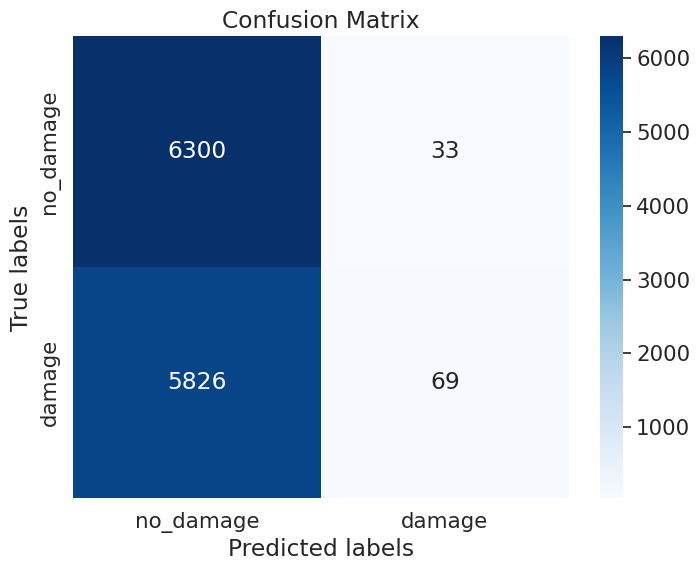

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Function to load InceptionV3 model with pretrained weights
def create_inception_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Adding a fully-connected layer
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Output layer
    model = Model(inputs=base_model.input, outputs=predictions)
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    return model

# Function to evaluate InceptionV3 model on test data
def eval_inception_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=(299, 299),  # InceptionV3 requires input size of 299x299
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

# Create and compile InceptionV3 model
inception_model = create_inception_model()
inception_model.compile(optimizer='adam',
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])

# Evaluate InceptionV3 model on test data
test_labels, predictions = eval_inception_model_on_test(inception_model)

# Sensitivity, F1-score, precision, recall
conf_matrix = confusion_matrix(test_labels, predictions.round())
classification_rep = classification_report(test_labels, predictions.round())

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

sns.set(font_scale=1.4)  # Adjust font size
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['no_damage', 'damage'], yticklabels=['no_damage', 'damage'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                 

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_8  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_22 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 3229889 (12.32 MB)
Trainable params: 1025 (4.00 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________
Epoch 1/20
34/34 [==============================] - 4s 52ms/step - loss: 0.6712 - accuracy: 0.5915 - val_loss: 0.5971 - val_accuracy: 0.7011
Epo

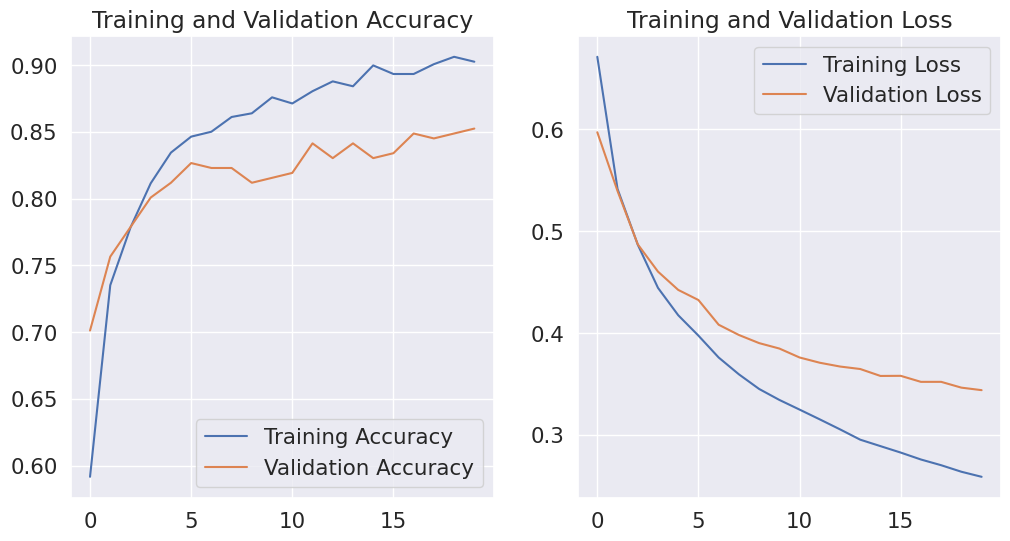

In [ ]:
from tensorflow.keras.applications import MobileNet

# Define input shape for MobileNet
IMG_SHAPE = (128, 128, 3)

# Load the MobileNet model
mobilenet = MobileNet(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

# Freeze the layers in the MobileNet model
for layer in mobilenet.layers:
    layer.trainable = False

# Print the summary of the MobileNet model
mobilenet.summary()

# Define a global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Get the output of the MobileNet model and pass it through the global average pooling layer
feature_batch = mobilenet(image_batch)
feature_batch_average = global_average_layer(feature_batch)

# Define the prediction layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Combine the MobileNet model with the global average pooling layer and the prediction layer
model_mobilenet = tf.keras.Sequential([mobilenet, global_average_layer, prediction_layer])

# Compile the model
base_learning_rate = 0.0001
model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Print the summary of the model
model_mobilenet.summary()

# Train the model
history_mobilenet = model_mobilenet.fit(train_ds, epochs=20, validation_data=val_ds)

# Plot the training history
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']

loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


17225924/17225924 [==============================] - 0s 0us/step
Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 2s 27ms/step


Predicting on Test Data:   1%|          | 1/96 [00:05<08:09,  5.15s/it]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:05<03:34,  2.28s/it]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:05<02:06,  1.36s/it]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:06<01:30,  1.01it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:06<01:06,  1.37it/s]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:06<00:51,  1.74it/s]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:06<00:43,  2.06it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:07<00:36,  2.39it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:07<00:36,  2.41it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:07<00:33,  2.60it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:08<00:33,  2.50it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:08<00:32,  2.61it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:09<00:36,  2.27it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:09<00:39,  2.06it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:10<00:40,  1.98it/s]

4/4 [==============================] - 0s 51ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:10<00:39,  2.02it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:11<00:36,  2.19it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:11<00:30,  2.55it/s]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:11<00:28,  2.67it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:12<00:25,  2.93it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:12<00:23,  3.17it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:12<00:25,  2.90it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:13<00:23,  3.14it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:13<00:24,  2.88it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:13<00:26,  2.71it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:14<00:26,  2.64it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:14<00:28,  2.44it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:15<00:27,  2.45it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:15<00:27,  2.44it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:15<00:24,  2.71it/s]

4/4 [==============================] - 0s 41ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:16<00:22,  2.92it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:16<00:23,  2.76it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:16<00:23,  2.65it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:17<00:24,  2.56it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:17<00:24,  2.50it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:18<00:22,  2.63it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:18<00:20,  2.91it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:18<00:21,  2.74it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:19<00:19,  2.94it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:19<00:18,  3.06it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:19<00:19,  2.84it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:20<00:20,  2.65it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:20<00:18,  2.92it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:20<00:19,  2.72it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:21<00:18,  2.77it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:21<00:21,  2.37it/s]

4/4 [==============================] - 0s 42ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:22<00:19,  2.54it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:22<00:21,  2.22it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:23<00:21,  2.24it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:23<00:20,  2.24it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:24<00:21,  2.11it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:24<00:19,  2.20it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:24<00:16,  2.53it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:25<00:15,  2.63it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:25<00:15,  2.58it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:25<00:15,  2.53it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:26<00:15,  2.46it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:26<00:15,  2.45it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:27<00:13,  2.74it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:27<00:12,  3.00it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:27<00:10,  3.22it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:28<00:12,  2.73it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:28<00:11,  2.89it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:28<00:11,  2.67it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:29<00:11,  2.61it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:29<00:11,  2.56it/s]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:29<00:10,  2.80it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:30<00:10,  2.68it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:30<00:10,  2.62it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:31<00:10,  2.53it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:31<00:10,  2.38it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:32<00:10,  2.39it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:32<00:09,  2.41it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:32<00:08,  2.74it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:33<00:07,  2.65it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:33<00:06,  2.90it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:33<00:06,  3.02it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:34<00:05,  3.12it/s]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:34<00:06,  2.67it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:35<00:07,  2.26it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:35<00:06,  2.47it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:35<00:06,  2.25it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:36<00:06,  2.04it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:36<00:05,  2.38it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:37<00:04,  2.40it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:37<00:04,  2.39it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:37<00:03,  2.70it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:38<00:02,  2.84it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:38<00:02,  3.06it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:38<00:01,  3.22it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:38<00:01,  3.44it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:39<00:01,  3.58it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:39<00:00,  3.71it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:39<00:00,  3.88it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:40<00:00,  3.27it/s]

3/3 [==============================] - 1s 187ms/step


Predicting on Test Data: 100%|██████████| 96/96 [01:21<00:00,  1.17it/s]


Confusion Matrix:
[[5111 1222]
 [4663 1232]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.81      0.63      6333
           1       0.50      0.21      0.30      5895

    accuracy                           0.52     12228
   macro avg       0.51      0.51      0.46     12228
weighted avg       0.51      0.52      0.47     12228



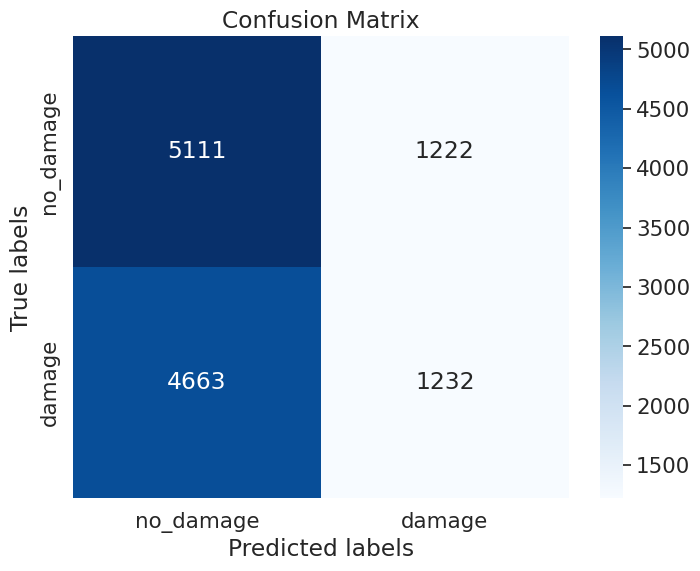

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Function to load MobileNet model with pretrained weights
def create_mobilenet_model():
    base_model = MobileNet(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Adding a fully-connected layer
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Output layer
    model = Model(inputs=base_model.input, outputs=predictions)
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    return model

# Function to evaluate MobileNet model on test data
def eval_mobilenet_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=(224, 224),  # MobileNet requires input size of 224x224
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

# Create and compile MobileNet model
mobilenet_model = create_mobilenet_model()
mobilenet_model.compile(optimizer='adam',
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])

# Evaluate MobileNet model on test data
test_labels, predictions = eval_mobilenet_model_on_test(mobilenet_model)

# Sensitivity, F1-score, precision, recall
conf_matrix = confusion_matrix(test_labels, predictions.round())
classification_rep = classification_report(test_labels, predictions.round())

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

sns.set(font_scale=1.4)  # Adjust font size
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['no_damage', 'damage'], yticklabels=['no_damage', 'damage'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_25 (Dense)            (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/20
34/34 [==

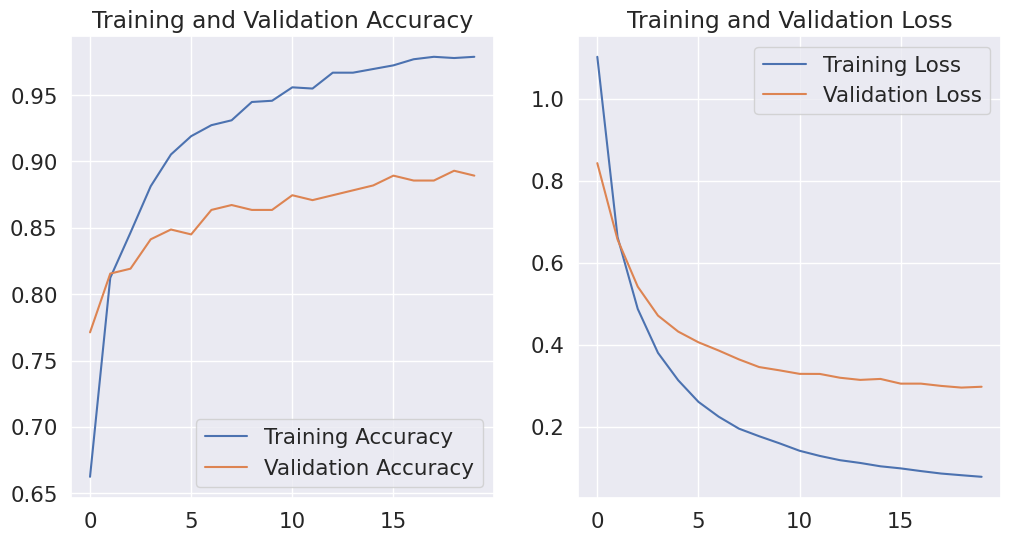

In [ ]:
from tensorflow.keras.applications import VGG16

IMAGE_SIZE = [128, 128]

# Load the VGG16 model
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the layers in the VGG16 model
for layer in vgg16.layers:
    layer.trainable = False

# Print the summary of the VGG16 model
vgg16.summary()

# Choose the layers to fine-tune
for layer in vgg16.layers[-5:]:
    print(layer.name)

# Define a global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Get the output of the VGG16 model and pass it through the global average pooling layer
image_input = tf.keras.Input(shape=IMG_SHAPE)
x = vgg16(image_input)
x = global_average_layer(x)

# Define the prediction layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Combine the VGG16 model with the global average pooling layer and the prediction layer
predictions = prediction_layer(x)

# Create the model
model_vgg16 = tf.keras.Model(inputs=image_input, outputs=predictions)

# Compile the model
base_learning_rate = 0.0001
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Print the summary of the model
model_vgg16.summary()

# Train the model
history_vgg16 = model_vgg16.fit(train_ds, epochs=20, validation_data=val_ds)

# Plot the training history
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']

loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 8s 93ms/step


Predicting on Test Data:   1%|          | 1/96 [00:09<15:20,  9.69s/it]

4/4 [==============================] - 0s 124ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:10<06:49,  4.36s/it]

4/4 [==============================] - 0s 127ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:11<04:17,  2.77s/it]

4/4 [==============================] - 0s 122ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:12<03:04,  2.00s/it]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:12<02:17,  1.51s/it]

4/4 [==============================] - 0s 124ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:13<01:51,  1.23s/it]

4/4 [==============================] - 0s 124ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:14<01:35,  1.07s/it]

4/4 [==============================] - 0s 126ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:14<01:22,  1.07it/s]

4/4 [==============================] - 0s 126ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:15<01:13,  1.19it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:16<01:09,  1.24it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:16<01:06,  1.28it/s]

4/4 [==============================] - 0s 121ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:17<01:04,  1.31it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:18<01:02,  1.34it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:18<01:01,  1.34it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:19<01:00,  1.34it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:20<00:59,  1.34it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:21<00:58,  1.35it/s]

4/4 [==============================] - 0s 124ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:21<00:58,  1.34it/s]

4/4 [==============================] - 0s 129ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:22<01:00,  1.28it/s]

4/4 [==============================] - 1s 127ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:23<01:00,  1.26it/s]

4/4 [==============================] - 0s 126ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:24<01:00,  1.23it/s]

4/4 [==============================] - 0s 127ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:25<00:56,  1.32it/s]

4/4 [==============================] - 0s 127ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:25<00:55,  1.32it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:26<00:51,  1.39it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:27<00:49,  1.45it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:27<00:47,  1.47it/s]

4/4 [==============================] - 0s 127ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:28<00:45,  1.50it/s]

4/4 [==============================] - 0s 129ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:29<00:44,  1.52it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:29<00:45,  1.48it/s]

4/4 [==============================] - 0s 129ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:30<00:45,  1.45it/s]

4/4 [==============================] - 0s 130ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:31<00:45,  1.43it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:31<00:45,  1.41it/s]

4/4 [==============================] - 0s 129ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:32<00:43,  1.46it/s]

4/4 [==============================] - 0s 129ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:33<00:41,  1.48it/s]

4/4 [==============================] - 0s 129ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:33<00:40,  1.51it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:34<00:39,  1.52it/s]

4/4 [==============================] - 0s 130ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:35<00:41,  1.43it/s]

4/4 [==============================] - 1s 130ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:36<00:43,  1.32it/s]

4/4 [==============================] - 0s 129ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:36<00:43,  1.32it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:37<00:41,  1.35it/s]

4/4 [==============================] - 0s 130ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:38<00:39,  1.41it/s]

4/4 [==============================] - 0s 130ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:39<00:38,  1.39it/s]

4/4 [==============================] - 0s 130ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:39<00:38,  1.38it/s]

4/4 [==============================] - 0s 130ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:40<00:36,  1.43it/s]

4/4 [==============================] - 0s 130ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:41<00:34,  1.46it/s]

4/4 [==============================] - 0s 130ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:41<00:34,  1.44it/s]

4/4 [==============================] - 0s 131ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:42<00:35,  1.37it/s]

4/4 [==============================] - 0s 130ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:43<00:34,  1.39it/s]

4/4 [==============================] - 0s 129ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:43<00:33,  1.42it/s]

4/4 [==============================] - 0s 129ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:44<00:31,  1.47it/s]

4/4 [==============================] - 0s 129ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:45<00:31,  1.44it/s]

4/4 [==============================] - 0s 126ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:46<00:30,  1.42it/s]

4/4 [==============================] - 0s 127ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:46<00:30,  1.40it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:47<00:28,  1.45it/s]

4/4 [==============================] - 0s 127ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:48<00:28,  1.42it/s]

4/4 [==============================] - 0s 130ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:49<00:30,  1.31it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:49<00:29,  1.32it/s]

4/4 [==============================] - 0s 128ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:50<00:28,  1.33it/s]

4/4 [==============================] - 0s 126ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:51<00:26,  1.39it/s]

4/4 [==============================] - 0s 127ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:51<00:25,  1.39it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:52<00:25,  1.38it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:53<00:24,  1.38it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:53<00:22,  1.44it/s]

4/4 [==============================] - 0s 122ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:54<00:22,  1.41it/s]

4/4 [==============================] - 0s 126ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:55<00:22,  1.36it/s]

4/4 [==============================] - 0s 126ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:56<00:21,  1.41it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:56<00:19,  1.46it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:57<00:18,  1.50it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:58<00:18,  1.45it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:58<00:18,  1.42it/s]

4/4 [==============================] - 0s 124ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:59<00:17,  1.40it/s]

4/4 [==============================] - 0s 124ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [01:00<00:16,  1.44it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [01:01<00:17,  1.30it/s]

4/4 [==============================] - 0s 126ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [01:02<00:17,  1.29it/s]

4/4 [==============================] - 1s 124ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [01:02<00:16,  1.24it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [01:03<00:15,  1.33it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  80%|████████  | 77/96 [01:04<00:13,  1.40it/s]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [01:04<00:12,  1.45it/s]

4/4 [==============================] - 0s 122ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [01:05<00:11,  1.49it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [01:06<00:10,  1.46it/s]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [01:06<00:10,  1.43it/s]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [01:07<00:10,  1.36it/s]

4/4 [==============================] - 0s 122ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [01:08<00:09,  1.42it/s]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [01:09<00:08,  1.39it/s]

4/4 [==============================] - 0s 124ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [01:09<00:07,  1.43it/s]

4/4 [==============================] - 0s 125ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [01:10<00:06,  1.48it/s]

4/4 [==============================] - 0s 124ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [01:11<00:06,  1.43it/s]

4/4 [==============================] - 0s 122ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [01:11<00:05,  1.40it/s]

4/4 [==============================] - 0s 122ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [01:12<00:05,  1.39it/s]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [01:13<00:04,  1.40it/s]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [01:13<00:03,  1.42it/s]

4/4 [==============================] - 0s 124ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [01:14<00:02,  1.45it/s]

4/4 [==============================] - 0s 126ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [01:15<00:02,  1.39it/s]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [01:16<00:01,  1.38it/s]

4/4 [==============================] - 0s 123ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [01:16<00:00,  1.47it/s]

3/3 [==============================] - 2s 933ms/step


Predicting on Test Data: 100%|██████████| 96/96 [01:18<00:00,  1.22it/s]

Confusion Matrix:
[[1404 4929]
 [2430 3465]]

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.22      0.28      6333
           1       0.41      0.59      0.48      5895

    accuracy                           0.40     12228
   macro avg       0.39      0.40      0.38     12228
weighted avg       0.39      0.40      0.38     12228



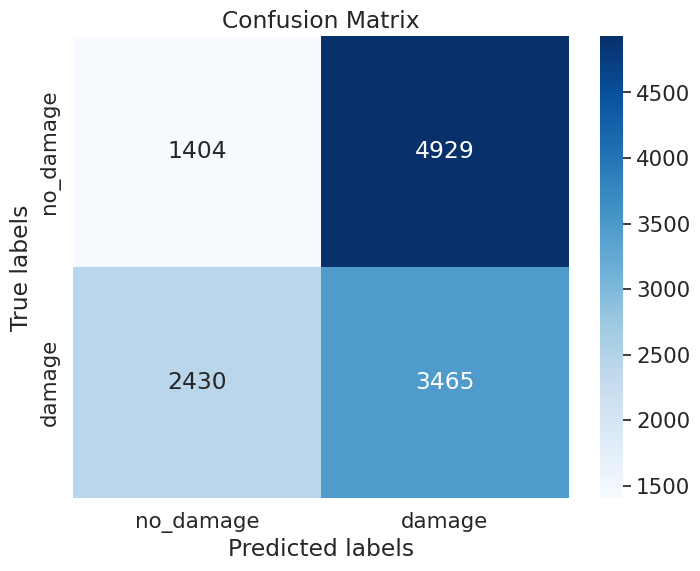

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Function to load VGG16 model with pretrained weights
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Adding a fully-connected layer
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Output layer
    model = Model(inputs=base_model.input, outputs=predictions)
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    return model

# Function to evaluate VGG16 model on test data
def eval_vgg16_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=(224, 224),  # VGG16 requires input size of 224x224
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

# Create and compile VGG16 model
vgg16_model = create_vgg16_model()
vgg16_model.compile(optimizer='adam',
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

# Evaluate VGG16 model on test data
test_labels, predictions = eval_vgg16_model_on_test(vgg16_model)

# Sensitivity, F1-score, precision, recall
conf_matrix = confusion_matrix(test_labels, predictions.round())
classification_rep = classification_report(test_labels, predictions.round())

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

sns.set(font_scale=1.4)  # Adjust font size
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['no_damage', 'damage'], yticklabels=['no_damage', 'damage'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 63, 63, 32)           864       ['input_14[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 63, 63, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_28 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________
Epoch 1/20
34/34 [==============================] - 11s 176ms/step - loss: 1.1016 

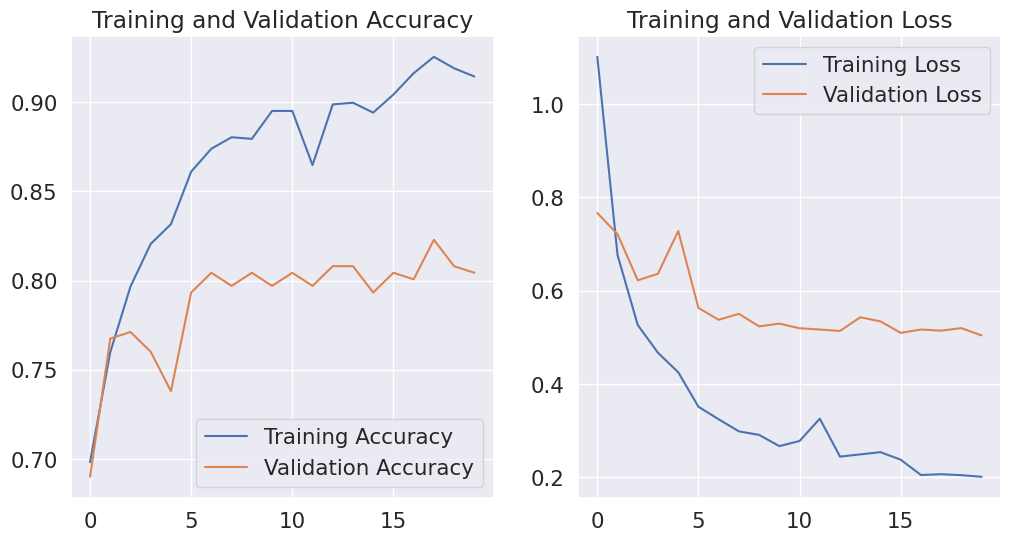

In [ ]:
from tensorflow.keras.applications import Xception

IMAGE_SIZE = [128, 128]

# Load the Xception model
xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the layers in the Xception model
for layer in xception.layers:
    layer.trainable = False

# Print the summary of the Xception model
xception.summary()

# Choose the layers to fine-tune
for layer in xception.layers[-5:]:
    print(layer.name)

# Define a global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Get the output of the Xception model and pass it through the global average pooling layer
image_input = tf.keras.Input(shape=IMG_SHAPE)
x = xception(image_input)
x = global_average_layer(x)

# Define the prediction layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Combine the Xception model with the global average pooling layer and the prediction layer
predictions = prediction_layer(x)

# Create the model
model_xception = tf.keras.Model(inputs=image_input, outputs=predictions)

# Compile the model
base_learning_rate = 0.0001
model_xception.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Print the summary of the model
model_xception.summary()

# Train the model
history_xception = model_xception.fit(train_ds, epochs=20, validation_data=val_ds)

# Plot the training history
acc = history_xception.history['accuracy']
val_acc = history_xception.history['val_accuracy']

loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 7s 154ms/step


Predicting on Test Data:   1%|          | 1/96 [00:08<13:27,  8.50s/it]

4/4 [==============================] - 1s 218ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:09<06:28,  4.13s/it]

4/4 [==============================] - 1s 217ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:10<04:13,  2.72s/it]

4/4 [==============================] - 1s 221ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:11<03:10,  2.07s/it]

4/4 [==============================] - 1s 218ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:12<02:35,  1.71s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:13<02:12,  1.47s/it]

4/4 [==============================] - 1s 221ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:15<02:08,  1.44s/it]

4/4 [==============================] - 1s 224ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:16<01:57,  1.34s/it]

4/4 [==============================] - 1s 218ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:17<01:54,  1.32s/it]

4/4 [==============================] - 1s 212ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:18<01:53,  1.32s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:19<01:44,  1.23s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:21<01:42,  1.22s/it]

4/4 [==============================] - 1s 224ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:22<01:38,  1.19s/it]

4/4 [==============================] - 1s 223ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:23<01:33,  1.14s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:24<01:30,  1.12s/it]

4/4 [==============================] - 1s 224ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:25<01:29,  1.11s/it]

4/4 [==============================] - 1s 227ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:26<01:27,  1.11s/it]

4/4 [==============================] - 1s 225ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:27<01:32,  1.19s/it]

4/4 [==============================] - 1s 232ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:28<01:29,  1.17s/it]

4/4 [==============================] - 1s 230ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:30<01:30,  1.19s/it]

4/4 [==============================] - 1s 231ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:31<01:41,  1.36s/it]

4/4 [==============================] - 1s 229ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:33<01:34,  1.27s/it]

4/4 [==============================] - 1s 227ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:34<01:28,  1.22s/it]

4/4 [==============================] - 1s 228ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:35<01:25,  1.19s/it]

4/4 [==============================] - 1s 227ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:36<01:28,  1.25s/it]

4/4 [==============================] - 1s 228ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:37<01:24,  1.20s/it]

4/4 [==============================] - 1s 224ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:39<01:26,  1.25s/it]

4/4 [==============================] - 1s 227ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:40<01:21,  1.20s/it]

4/4 [==============================] - 1s 230ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:41<01:21,  1.22s/it]

4/4 [==============================] - 1s 231ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:42<01:26,  1.31s/it]

4/4 [==============================] - 1s 236ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:44<01:23,  1.29s/it]

4/4 [==============================] - 1s 224ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:45<01:18,  1.23s/it]

4/4 [==============================] - 1s 223ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:46<01:15,  1.19s/it]

4/4 [==============================] - 1s 225ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:47<01:12,  1.17s/it]

4/4 [==============================] - 1s 225ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:48<01:15,  1.23s/it]

4/4 [==============================] - 1s 224ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:49<01:10,  1.17s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:51<01:08,  1.15s/it]

4/4 [==============================] - 1s 223ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:52<01:06,  1.15s/it]

4/4 [==============================] - 1s 223ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:53<01:03,  1.12s/it]

4/4 [==============================] - 1s 225ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:54<01:01,  1.11s/it]

4/4 [==============================] - 1s 223ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:55<01:04,  1.18s/it]

4/4 [==============================] - 1s 221ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:56<01:05,  1.22s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:58<01:02,  1.17s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:59<00:58,  1.13s/it]

4/4 [==============================] - 1s 221ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [01:00<01:01,  1.20s/it]

4/4 [==============================] - 1s 219ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [01:02<01:05,  1.31s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [01:03<01:00,  1.23s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  50%|█████     | 48/96 [01:04<00:56,  1.18s/it]

4/4 [==============================] - 1s 221ms/step


Predicting on Test Data:  51%|█████     | 49/96 [01:05<00:54,  1.15s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [01:06<00:51,  1.13s/it]

4/4 [==============================] - 1s 224ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [01:07<00:50,  1.11s/it]

4/4 [==============================] - 1s 215ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [01:08<00:51,  1.17s/it]

4/4 [==============================] - 1s 216ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [01:09<00:51,  1.19s/it]

4/4 [==============================] - 1s 219ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [01:10<00:47,  1.14s/it]

4/4 [==============================] - 1s 221ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [01:12<00:47,  1.15s/it]

4/4 [==============================] - 1s 217ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [01:13<00:44,  1.12s/it]

4/4 [==============================] - 1s 218ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [01:14<00:43,  1.11s/it]

4/4 [==============================] - 1s 219ms/step


Predicting on Test Data:  60%|██████    | 58/96 [01:15<00:45,  1.19s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [01:16<00:42,  1.14s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [01:17<00:40,  1.12s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [01:18<00:38,  1.11s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [01:19<00:37,  1.10s/it]

4/4 [==============================] - 1s 229ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [01:21<00:36,  1.11s/it]

4/4 [==============================] - 1s 216ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [01:22<00:39,  1.23s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [01:23<00:37,  1.21s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [01:25<00:37,  1.26s/it]

4/4 [==============================] - 1s 221ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [01:26<00:37,  1.29s/it]

4/4 [==============================] - 1s 218ms/step


Predicting on Test Data:  71%|███████   | 68/96 [01:27<00:37,  1.32s/it]

4/4 [==============================] - 1s 217ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [01:29<00:36,  1.34s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [01:30<00:32,  1.25s/it]

4/4 [==============================] - 1s 221ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [01:31<00:29,  1.20s/it]

4/4 [==============================] - 1s 218ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [01:32<00:28,  1.19s/it]

4/4 [==============================] - 1s 229ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [01:33<00:26,  1.16s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [01:34<00:26,  1.22s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [01:36<00:24,  1.19s/it]

4/4 [==============================] - 1s 221ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [01:37<00:23,  1.15s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  80%|████████  | 77/96 [01:38<00:21,  1.12s/it]

4/4 [==============================] - 1s 218ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [01:39<00:19,  1.10s/it]

4/4 [==============================] - 1s 220ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [01:40<00:18,  1.10s/it]

4/4 [==============================] - 1s 219ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [01:41<00:17,  1.09s/it]

4/4 [==============================] - 1s 223ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [01:42<00:16,  1.12s/it]

4/4 [==============================] - 1s 218ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [01:43<00:15,  1.10s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [01:44<00:14,  1.08s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [01:45<00:12,  1.08s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [01:46<00:12,  1.12s/it]

4/4 [==============================] - 1s 226ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [01:48<00:11,  1.14s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [01:49<00:10,  1.14s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [01:50<00:08,  1.12s/it]

4/4 [==============================] - 1s 224ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [01:51<00:07,  1.14s/it]

4/4 [==============================] - 1s 219ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [01:52<00:06,  1.12s/it]

4/4 [==============================] - 1s 226ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [01:53<00:05,  1.11s/it]

4/4 [==============================] - 1s 225ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [01:54<00:04,  1.10s/it]

4/4 [==============================] - 1s 224ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [01:55<00:03,  1.12s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [01:56<00:02,  1.08s/it]

4/4 [==============================] - 1s 222ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [01:57<00:01,  1.06s/it]

3/3 [==============================] - 3s 1s/step


Predicting on Test Data: 100%|██████████| 96/96 [02:21<00:00,  1.48s/it]


Confusion Matrix:
[[  57 6276]
 [ 192 5703]]

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.01      0.02      6333
           1       0.48      0.97      0.64      5895

    accuracy                           0.47     12228
   macro avg       0.35      0.49      0.33     12228
weighted avg       0.35      0.47      0.32     12228



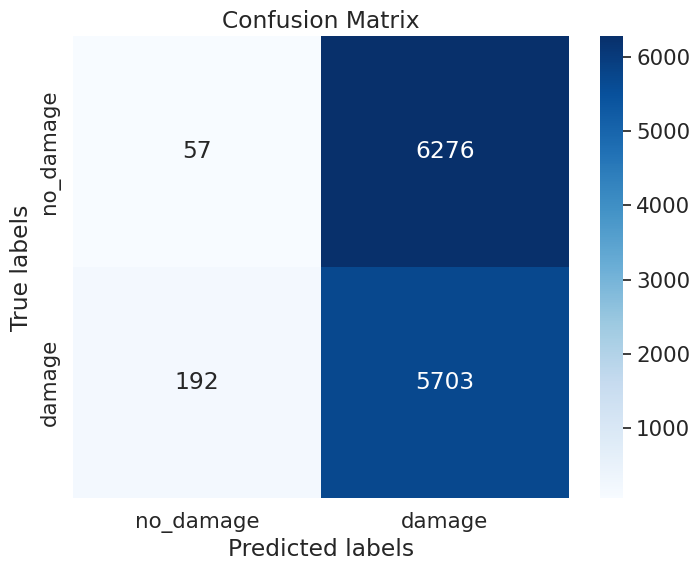

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Function to load Xception model with pretrained weights
def create_xception_model():
    base_model = Xception(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Adding a fully-connected layer
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Output layer
    model = Model(inputs=base_model.input, outputs=predictions)
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    return model

# Function to evaluate Xception model on test data
def eval_xception_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=(299, 299),  # Xception requires input size of 299x299
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

# Create and compile Xception model
xception_model = create_xception_model()
xception_model.compile(optimizer='adam',
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=['accuracy'])

# Evaluate Xception model on test data
test_labels, predictions = eval_xception_model_on_test(xception_model)

# Sensitivity, F1-score, precision, recall
conf_matrix = confusion_matrix(test_labels, predictions.round())
classification_rep = classification_report(test_labels, predictions.round())

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

sns.set(font_scale=1.4)  # Adjust font size
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['no_damage', 'damage'], yticklabels=['no_damage', 'damage'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 4 (GlobalAveragePooling2D)                                      
                                                                 
 dense_31 (Dense)            (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________
Epoch 1/20
34/34 [==============================] - 4s 72ms/step - loss: 1.2044 - a

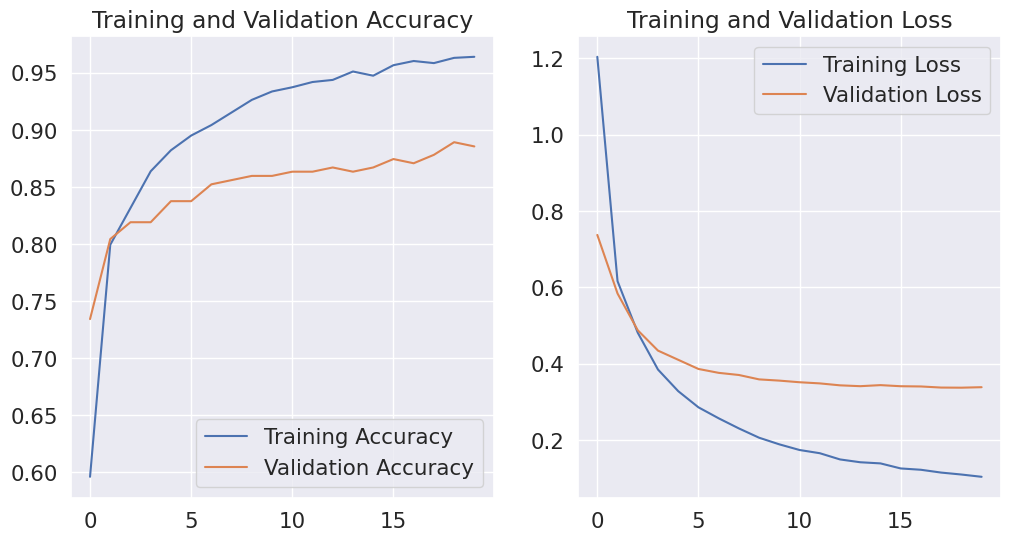

In [ ]:
from tensorflow.keras.applications import VGG19

IMAGE_SIZE = [128, 128]

# Load the VGG19 model
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the layers in the VGG19 model
for layer in vgg19.layers:
    layer.trainable = False

# Print the summary of the VGG19 model
vgg19.summary()

# Choose the layers to fine-tune
for layer in vgg19.layers[-5:]:
    print(layer.name)

# Define a global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Get the output of the VGG19 model and pass it through the global average pooling layer
image_input = tf.keras.Input(shape=IMG_SHAPE)
x = vgg19(image_input)
x = global_average_layer(x)

# Define the prediction layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Combine the VGG19 model with the global average pooling layer and the prediction layer
predictions = prediction_layer(x)

# Create the model
model_vgg19 = tf.keras.Model(inputs=image_input, outputs=predictions)

# Compile the model
base_learning_rate = 0.0001
model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

# Print the summary of the model
model_vgg19.summary()

# Train the model
history_vgg19 = model_vgg19.fit(train_ds, epochs=20, validation_data=val_ds)

# Plot the training history
acc = history_vgg19.history['accuracy']
val_acc = history_vgg19.history['val_accuracy']

loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 1s 168ms/step


Predicting on Test Data:   1%|          | 1/96 [00:01<02:46,  1.75s/it]

4/4 [==============================] - 0s 147ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:02<01:47,  1.14s/it]

4/4 [==============================] - 0s 148ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:03<01:28,  1.05it/s]

4/4 [==============================] - 1s 150ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:03<01:19,  1.15it/s]

4/4 [==============================] - 1s 148ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:05<01:35,  1.05s/it]

4/4 [==============================] - 0s 148ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:06<01:24,  1.07it/s]

4/4 [==============================] - 1s 146ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:06<01:19,  1.12it/s]

4/4 [==============================] - 1s 150ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:07<01:15,  1.17it/s]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:08<01:11,  1.22it/s]

4/4 [==============================] - 1s 151ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:09<01:12,  1.18it/s]

4/4 [==============================] - 1s 151ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:10<01:29,  1.05s/it]

4/4 [==============================] - 0s 148ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:11<01:19,  1.06it/s]

4/4 [==============================] - 1s 140ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:12<01:13,  1.13it/s]

4/4 [==============================] - 0s 151ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:12<01:08,  1.20it/s]

4/4 [==============================] - 1s 151ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:13<01:06,  1.22it/s]

4/4 [==============================] - 0s 152ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:14<01:03,  1.26it/s]

4/4 [==============================] - 0s 153ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:15<01:01,  1.29it/s]

4/4 [==============================] - 0s 152ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:15<00:59,  1.32it/s]

4/4 [==============================] - 1s 153ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:17<01:12,  1.06it/s]

4/4 [==============================] - 0s 152ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:17<01:06,  1.14it/s]

4/4 [==============================] - 1s 153ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:19<01:16,  1.02s/it]

4/4 [==============================] - 0s 153ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:20<01:09,  1.07it/s]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:21<01:18,  1.08s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:23<01:28,  1.23s/it]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:24<01:30,  1.27s/it]

4/4 [==============================] - 0s 153ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:25<01:17,  1.11s/it]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:25<01:08,  1.00it/s]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:26<01:02,  1.08it/s]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:28<01:11,  1.06s/it]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:28<01:03,  1.03it/s]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:29<00:58,  1.10it/s]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:30<01:08,  1.06s/it]

4/4 [==============================] - 1s 159ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:31<01:01,  1.03it/s]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:32<00:56,  1.09it/s]

4/4 [==============================] - 1s 161ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:33<00:54,  1.11it/s]

4/4 [==============================] - 1s 160ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:34<00:54,  1.10it/s]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:35<00:54,  1.09it/s]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:36<01:00,  1.05s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:37<00:54,  1.04it/s]

4/4 [==============================] - 0s 148ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:38<01:00,  1.08s/it]

4/4 [==============================] - 1s 160ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:40<01:05,  1.19s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:41<01:07,  1.24s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:42<00:57,  1.09s/it]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:43<01:01,  1.17s/it]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:45<01:02,  1.23s/it]

4/4 [==============================] - 0s 154ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:45<00:54,  1.09s/it]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:46<00:50,  1.03s/it]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:47<00:46,  1.03it/s]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:48<00:53,  1.13s/it]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:49<00:47,  1.04s/it]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:50<00:42,  1.05it/s]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:51<00:38,  1.13it/s]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:52<00:36,  1.17it/s]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:52<00:34,  1.22it/s]

4/4 [==============================] - 0s 153ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:53<00:32,  1.26it/s]

4/4 [==============================] - 0s 154ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:54<00:38,  1.03it/s]

4/4 [==============================] - 1s 156ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:56<00:42,  1.09s/it]

4/4 [==============================] - 1s 154ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:57<00:37,  1.02it/s]

4/4 [==============================] - 1s 153ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:58<00:41,  1.13s/it]

4/4 [==============================] - 1s 155ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:59<00:44,  1.24s/it]

4/4 [==============================] - 1s 152ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [01:00<00:38,  1.10s/it]

4/4 [==============================] - 1s 152ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [01:01<00:33,  1.01it/s]

4/4 [==============================] - 0s 151ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [01:02<00:29,  1.10it/s]

4/4 [==============================] - 1s 152ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [01:02<00:27,  1.16it/s]

4/4 [==============================] - 0s 151ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [01:03<00:25,  1.21it/s]

4/4 [==============================] - 1s 152ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [01:04<00:24,  1.23it/s]

4/4 [==============================] - 1s 153ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [01:05<00:24,  1.16it/s]

4/4 [==============================] - 1s 158ms/step


Predicting on Test Data:  71%|███████   | 68/96 [01:06<00:24,  1.14it/s]

4/4 [==============================] - 0s 153ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [01:07<00:22,  1.20it/s]

4/4 [==============================] - 0s 148ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [01:07<00:20,  1.25it/s]

4/4 [==============================] - 0s 151ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [01:08<00:19,  1.28it/s]

4/4 [==============================] - 1s 151ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [01:09<00:23,  1.04it/s]

4/4 [==============================] - 1s 149ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [01:10<00:21,  1.07it/s]

4/4 [==============================] - 1s 152ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [01:11<00:19,  1.12it/s]

4/4 [==============================] - 1s 157ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [01:12<00:17,  1.18it/s]

4/4 [==============================] - 0s 151ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [01:13<00:17,  1.17it/s]

4/4 [==============================] - 0s 151ms/step


Predicting on Test Data:  80%|████████  | 77/96 [01:13<00:15,  1.22it/s]

4/4 [==============================] - 1s 150ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [01:15<00:17,  1.02it/s]

4/4 [==============================] - 0s 151ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [01:16<00:15,  1.11it/s]

4/4 [==============================] - 1s 151ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [01:16<00:13,  1.17it/s]

4/4 [==============================] - 0s 150ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [01:17<00:12,  1.22it/s]

4/4 [==============================] - 0s 149ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [01:18<00:11,  1.27it/s]

4/4 [==============================] - 0s 149ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [01:18<00:09,  1.30it/s]

4/4 [==============================] - 1s 149ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [01:19<00:09,  1.28it/s]

4/4 [==============================] - 1s 153ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [01:20<00:08,  1.29it/s]

4/4 [==============================] - 0s 149ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [01:21<00:07,  1.31it/s]

4/4 [==============================] - 0s 151ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [01:22<00:06,  1.33it/s]

4/4 [==============================] - 0s 151ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [01:22<00:06,  1.33it/s]

4/4 [==============================] - 0s 152ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [01:23<00:05,  1.32it/s]

4/4 [==============================] - 1s 152ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [01:24<00:04,  1.30it/s]

4/4 [==============================] - 0s 146ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [01:25<00:03,  1.28it/s]

4/4 [==============================] - 1s 150ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [01:26<00:03,  1.03it/s]

4/4 [==============================] - 0s 148ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [01:27<00:02,  1.09it/s]

4/4 [==============================] - 0s 149ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [01:28<00:01,  1.17it/s]

4/4 [==============================] - 0s 151ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [01:28<00:00,  1.23it/s]

3/3 [==============================] - 0s 148ms/step


Predicting on Test Data: 100%|██████████| 96/96 [02:21<00:00,  1.48s/it]


Confusion Matrix:
[[1584 4749]
 [1466 4429]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.25      0.34      6333
           1       0.48      0.75      0.59      5895

    accuracy                           0.49     12228
   macro avg       0.50      0.50      0.46     12228
weighted avg       0.50      0.49      0.46     12228



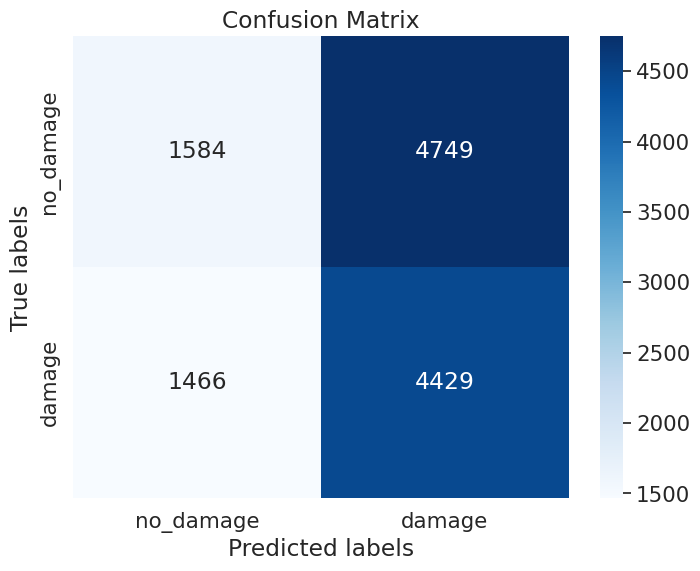

In [ ]:
from tensorflow.keras.applications import VGG19

# Function to load VGG19 model with pretrained weights
def create_vgg19_model():
    base_model = VGG19(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Adding a fully-connected layer
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Output layer
    model = Model(inputs=base_model.input, outputs=predictions)
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    return model

# Function to evaluate VGG19 model on test data
def eval_vgg19_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=(224, 224),  # VGG19 requires input size of 224x224
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

# Create and compile VGG19 model
vgg19_model = create_vgg19_model()
vgg19_model.compile(optimizer='adam',
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

# Evaluate VGG19 model on test data
test_labels, predictions = eval_vgg19_model_on_test(vgg19_model)

# Sensitivity, F1-score, precision, recall
conf_matrix = confusion_matrix(test_labels, predictions.round())
classification_rep = classification_report(test_labels, predictions.round())

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

sns.set(font_scale=1.4)  # Adjust font size
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['no_damage', 'damage'], yticklabels=['no_damage', 'damage'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

# Define the model architecture
def create_model(input_shape=(128, 128, 3)):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Function to preprocess user input image
def preprocess_image(image_path, img_dims=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(img_dims)
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to train and save the model
def train_and_save_model(train_data, val_data, model_save_path, epochs=20):
    # Create the model
    model = create_model()

    # Compile the model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data
    )

    # Save the model
    model.save(model_save_path)
    print("Model saved successfully as", model_save_path)

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
from glob import glob

# Define the model architecture
def create_model(input_shape=(128, 128, 3)):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Function to preprocess user input image
def preprocess_image(image_path, img_dims=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(img_dims)
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=(128, 128),  # Set image size directly here
        batch_size=32,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=(128, 128),  # Set image size directly here
        batch_size=32,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

def train_model_and_save():
    # Prepare train and validation datasets
    train_ds, val_ds = prepare_train_and_val_datasets()

    # Create model
    model = create_model()

    # Compile model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    # Train model
    model.fit(train_ds, epochs=20, validation_data=val_ds)

    # Save model
    model.save("hurricane_damage_model.h5")
    print("Model saved as hurricane_damage_model.h5")

if __name__ == "__main__":
    train_model_and_save()
